# Urban Region Function Classification

With the accelerating urbanization and building of smart cities in China, new challenges have arisen regarding urban planning and refined management. With the benefits of providing high spatial resolution and detailed information, high-resolution remote sensing images have been widely used in tackling problems like the classification of the functions of urban areas. Cities are built for us human beings and the functions of urban areas are closely intertwined with our daily life. By making full use of the data of remote sensing and user behavior, significant improvement can be expected from the models used for the classification of the functions of urban areas.

1. AI + Remote Sensing. On the data side, the potential of combining mobile big data and remote sensing images can be fully realized. On the technical side, artificial intelligence tools like deep learning could be put to good use.

2. Contribution to the open source of remote sensing data. Echoing the national strategic initiatives like "One Belt, One Road" and "China Go Abroad", the international cooperation and sharing of remote sensing data could be immensely expanded.

3. Facilitation of the industrial application. Cities as a complex system have served multiple functions for being the residential, commercial and business areas. This competition is of tremendous importance to the understanding of the urban spatial structure and refined management through the marriage of AI and satellite images. Hopefully, contestants would be inspired to come up with novel ideas and extend their solutions to industries like intelligent agriculture and smart environment.

**If you found this notebook useful some upvotes would be greatly appreciated! :) **

## Import required modules

In [16]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Images

In [ ]:
train_csv = []
for root, dirs, files in os.walk("./dataset/final_train/", topdown=True):
    for file in files:
        filePath = os.path.join(root, file)
        AreaID, CategoryID = file.split("_")
        train_csv.append([filePath, CategoryID[:3]])

test_csv = []
for root, dirs, files in os.walk("./dataset/final_test/", topdown=True):
    for file in files:
        filePath = os.path.join(root, file)
        AreaID, CategoryID = file, "000"
        test_csv.append([filePath, CategoryID[:3]])

In [3]:
# train_dehaze = []
# for root, dirs, files in os.walk("./dataset/train_dehaze", topdown=True):
#     for file in files:
#         filePath = os.path.join(root, file).replace("_dehaze", "")
#         AreaID, CategoryID = file.split("_")
#         train_dehaze.append([filePath, CategoryID[:3]])

# test_dehaze = []
# for root, dirs, files in os.walk("./dataset/test_dehaze", topdown=True):
#     for file in files:
#         filePath = os.path.join(root, file).replace("_dehaze", "")
#         AreaID, CategoryID = file, "000"
#         test_dehaze.append([filePath, CategoryID[:3]])

In [30]:
train_df = pd.DataFrame(train_csv, columns=["Id_x", "Target"])
train_df.Target = pd.to_numeric(train_df.Target)

test_df = pd.DataFrame(test_csv, columns=["Id_x", "Target"])
test_df.Target = pd.to_numeric(test_df.Target)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 2 columns):
Id        400000 non-null object
Target    400000 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.1+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
Id        100000 non-null object
Target    100000 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [7]:
train_df.head()

,Id,Target
0,./dataset/final_train/001\000003_001.jpg,1
1,./dataset/final_train/001\000007_001.jpg,1
2,./dataset/final_train/001\000008_001.jpg,1
3,./dataset/final_train/001\000009_001.jpg,1
4,./dataset/final_train/001\000013_001.jpg,1


In [8]:
test_df.head()

,Id,Target
0,./dataset/final_test/000000.jpg,0
1,./dataset/final_test/000001.jpg,0
2,./dataset/final_test/000002.jpg,0
3,./dataset/final_test/000003.jpg,0
4,./dataset/final_test/000004.jpg,0


In [19]:
train_df.Target = train_df.Target - 1

In [20]:
train_df.to_csv("./dataset/final_train.csv", index=False)
test_df.to_csv("./dataset/final_test.csv", index=False)

## 1.1 Inspect image labels distribution

In [9]:
target2label = {'1': 'Residential area',
 '2': 'School',
 '3': 'Industrial park',
 '4': 'Railway station',
 '5': 'Airport',
 '6': 'Park',
 '7': 'Shopping area',
 '8': 'Administrative district',
 '9': 'Hospital'}

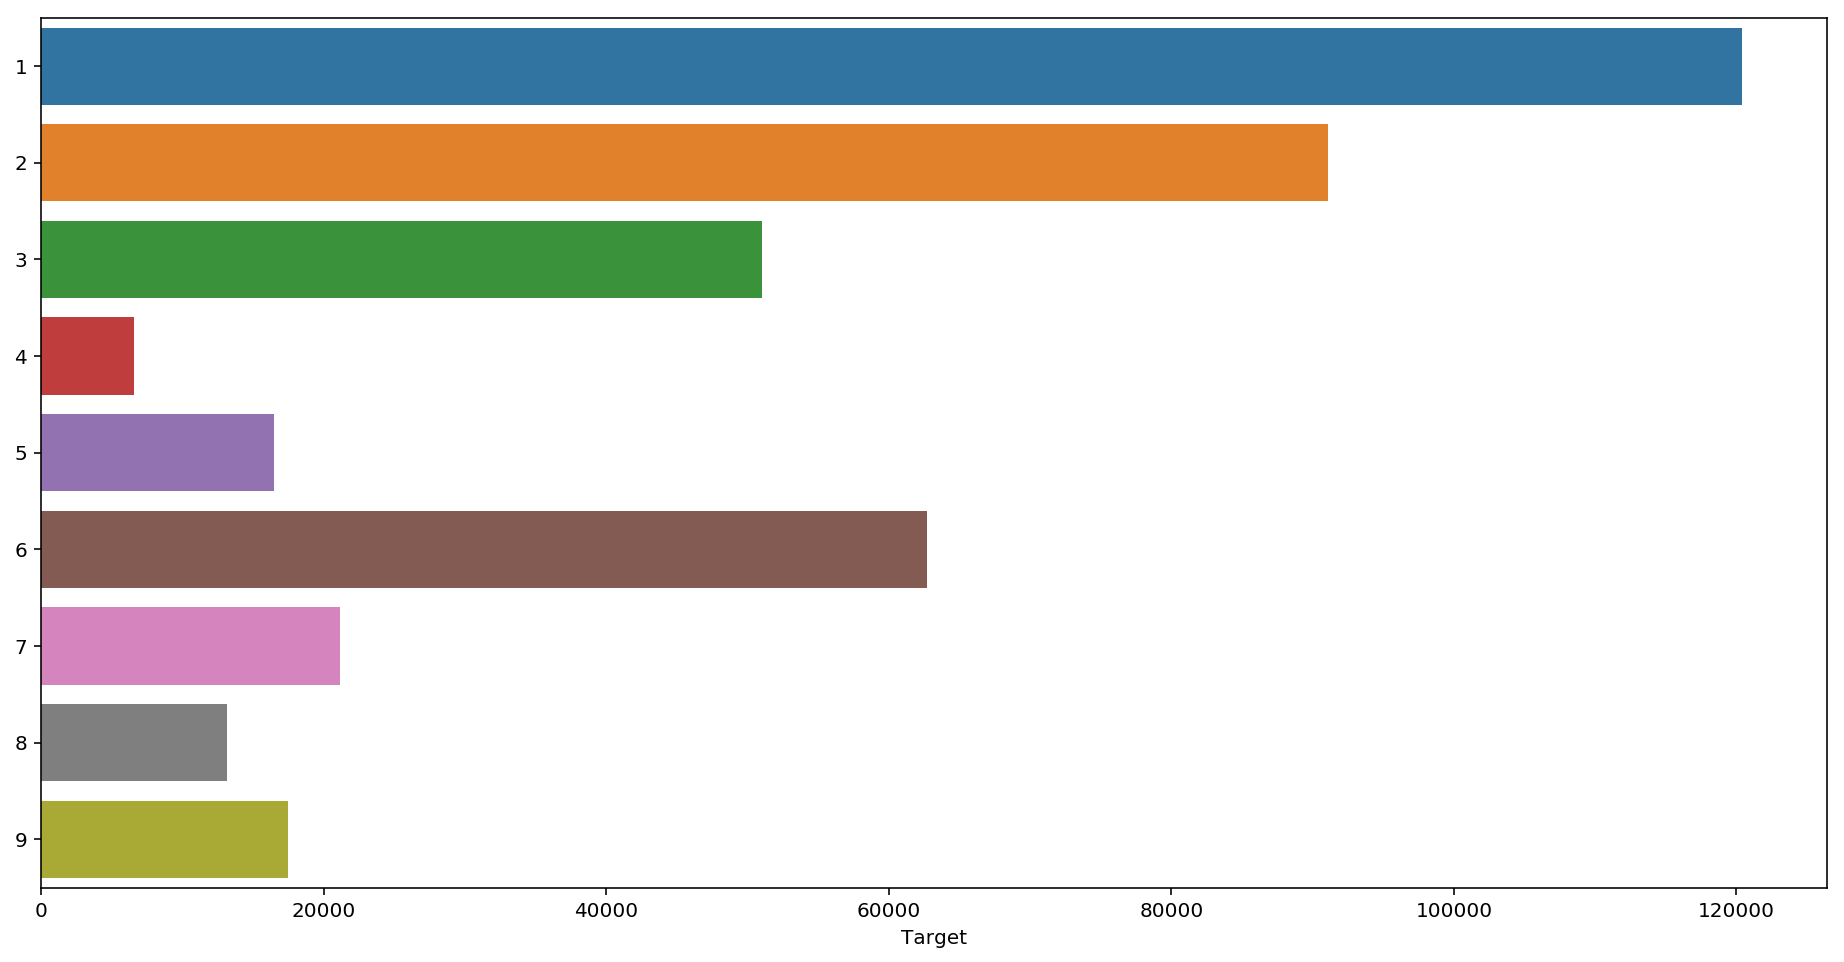

In [10]:
# Histogram of label instances
labels_s = train_df.Target.value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

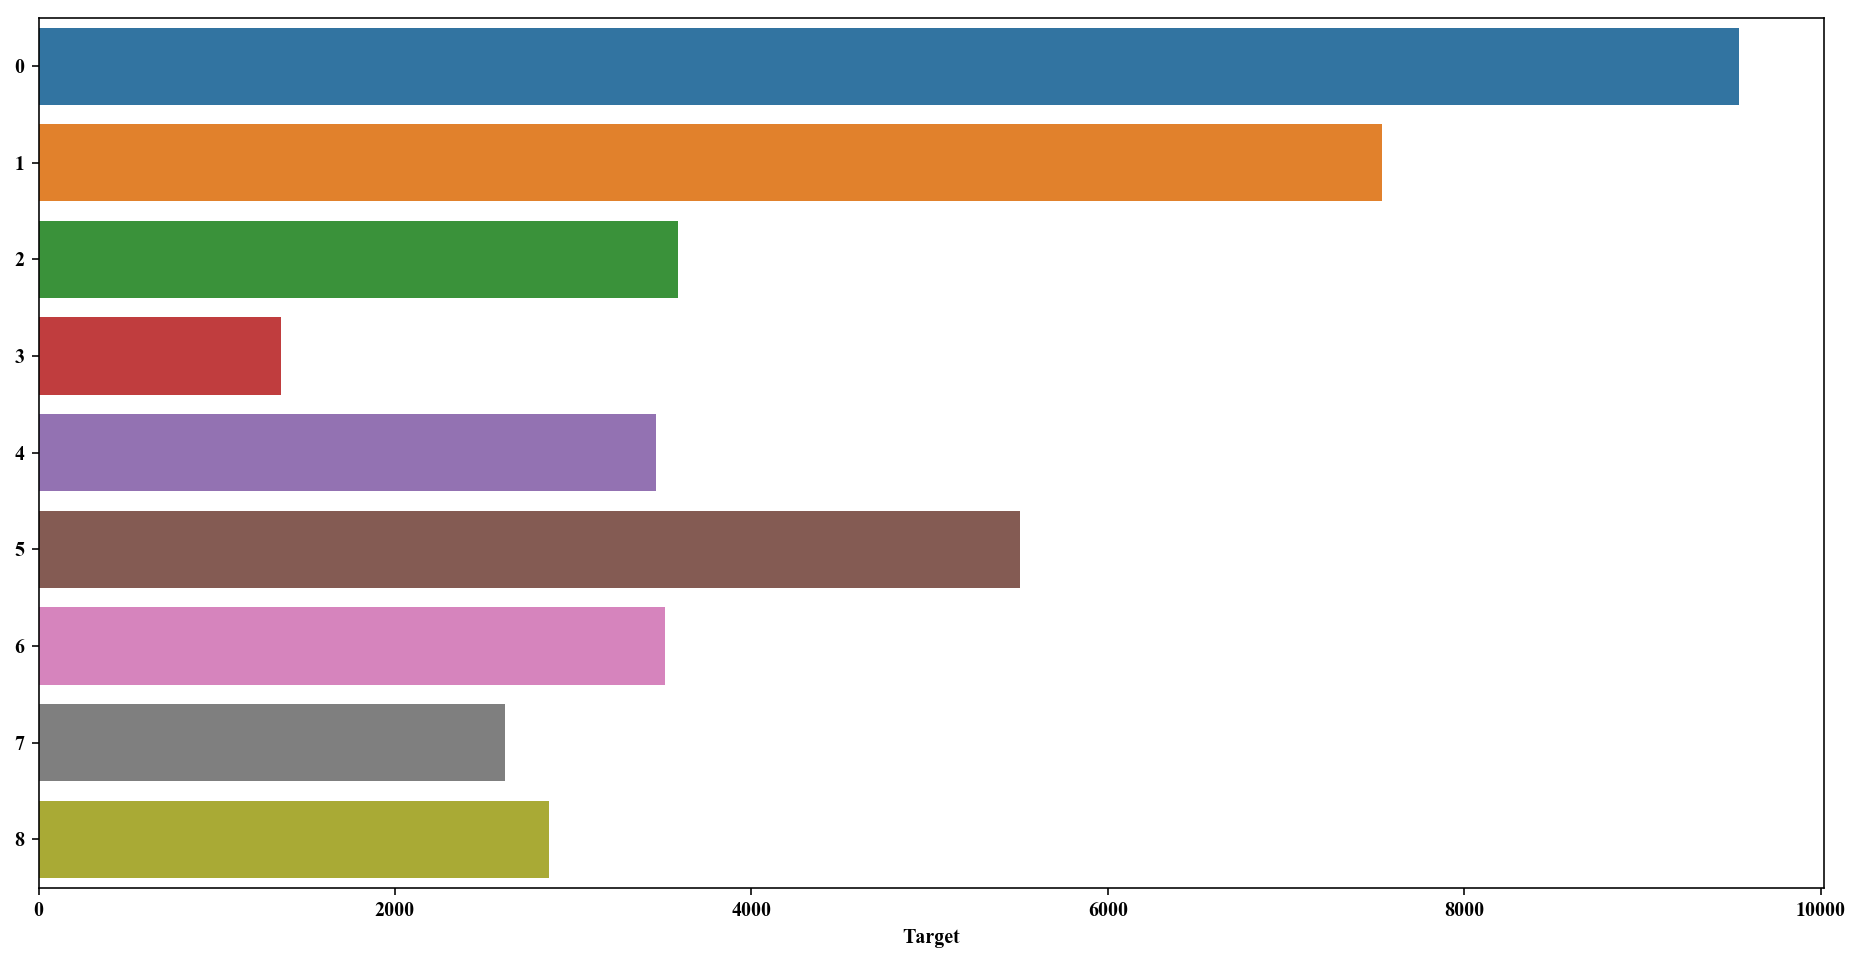

In [827]:
# Histogram of label instances
labels_s = train_df.Target.value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

In [32]:
train_df = pd.read_csv("./dataset/train.csv")

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
Id             40000 non-null object
Target         40000 non-null int64
black_ratio    40000 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 937.6+ KB


In [34]:
train_df.Target = train_df.Target - 1

In [36]:
train_df.describe()

,Target,black_ratio
count,40000.000000,40000.000000
mean,3.063500,0.007413
std,2.693316,0.077712
min,0.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,5.000000,0.000000
max,8.000000,1.000000


In [37]:
train_df.to_csv("./dataset/train.csv", index=False)

## 1.2 Images Visualization
Visualize some chip images to know what we are dealing with.
Lets vizualise 1 chip for the 9 images to get a sense of their differences.

In [17]:
from PIL import Image

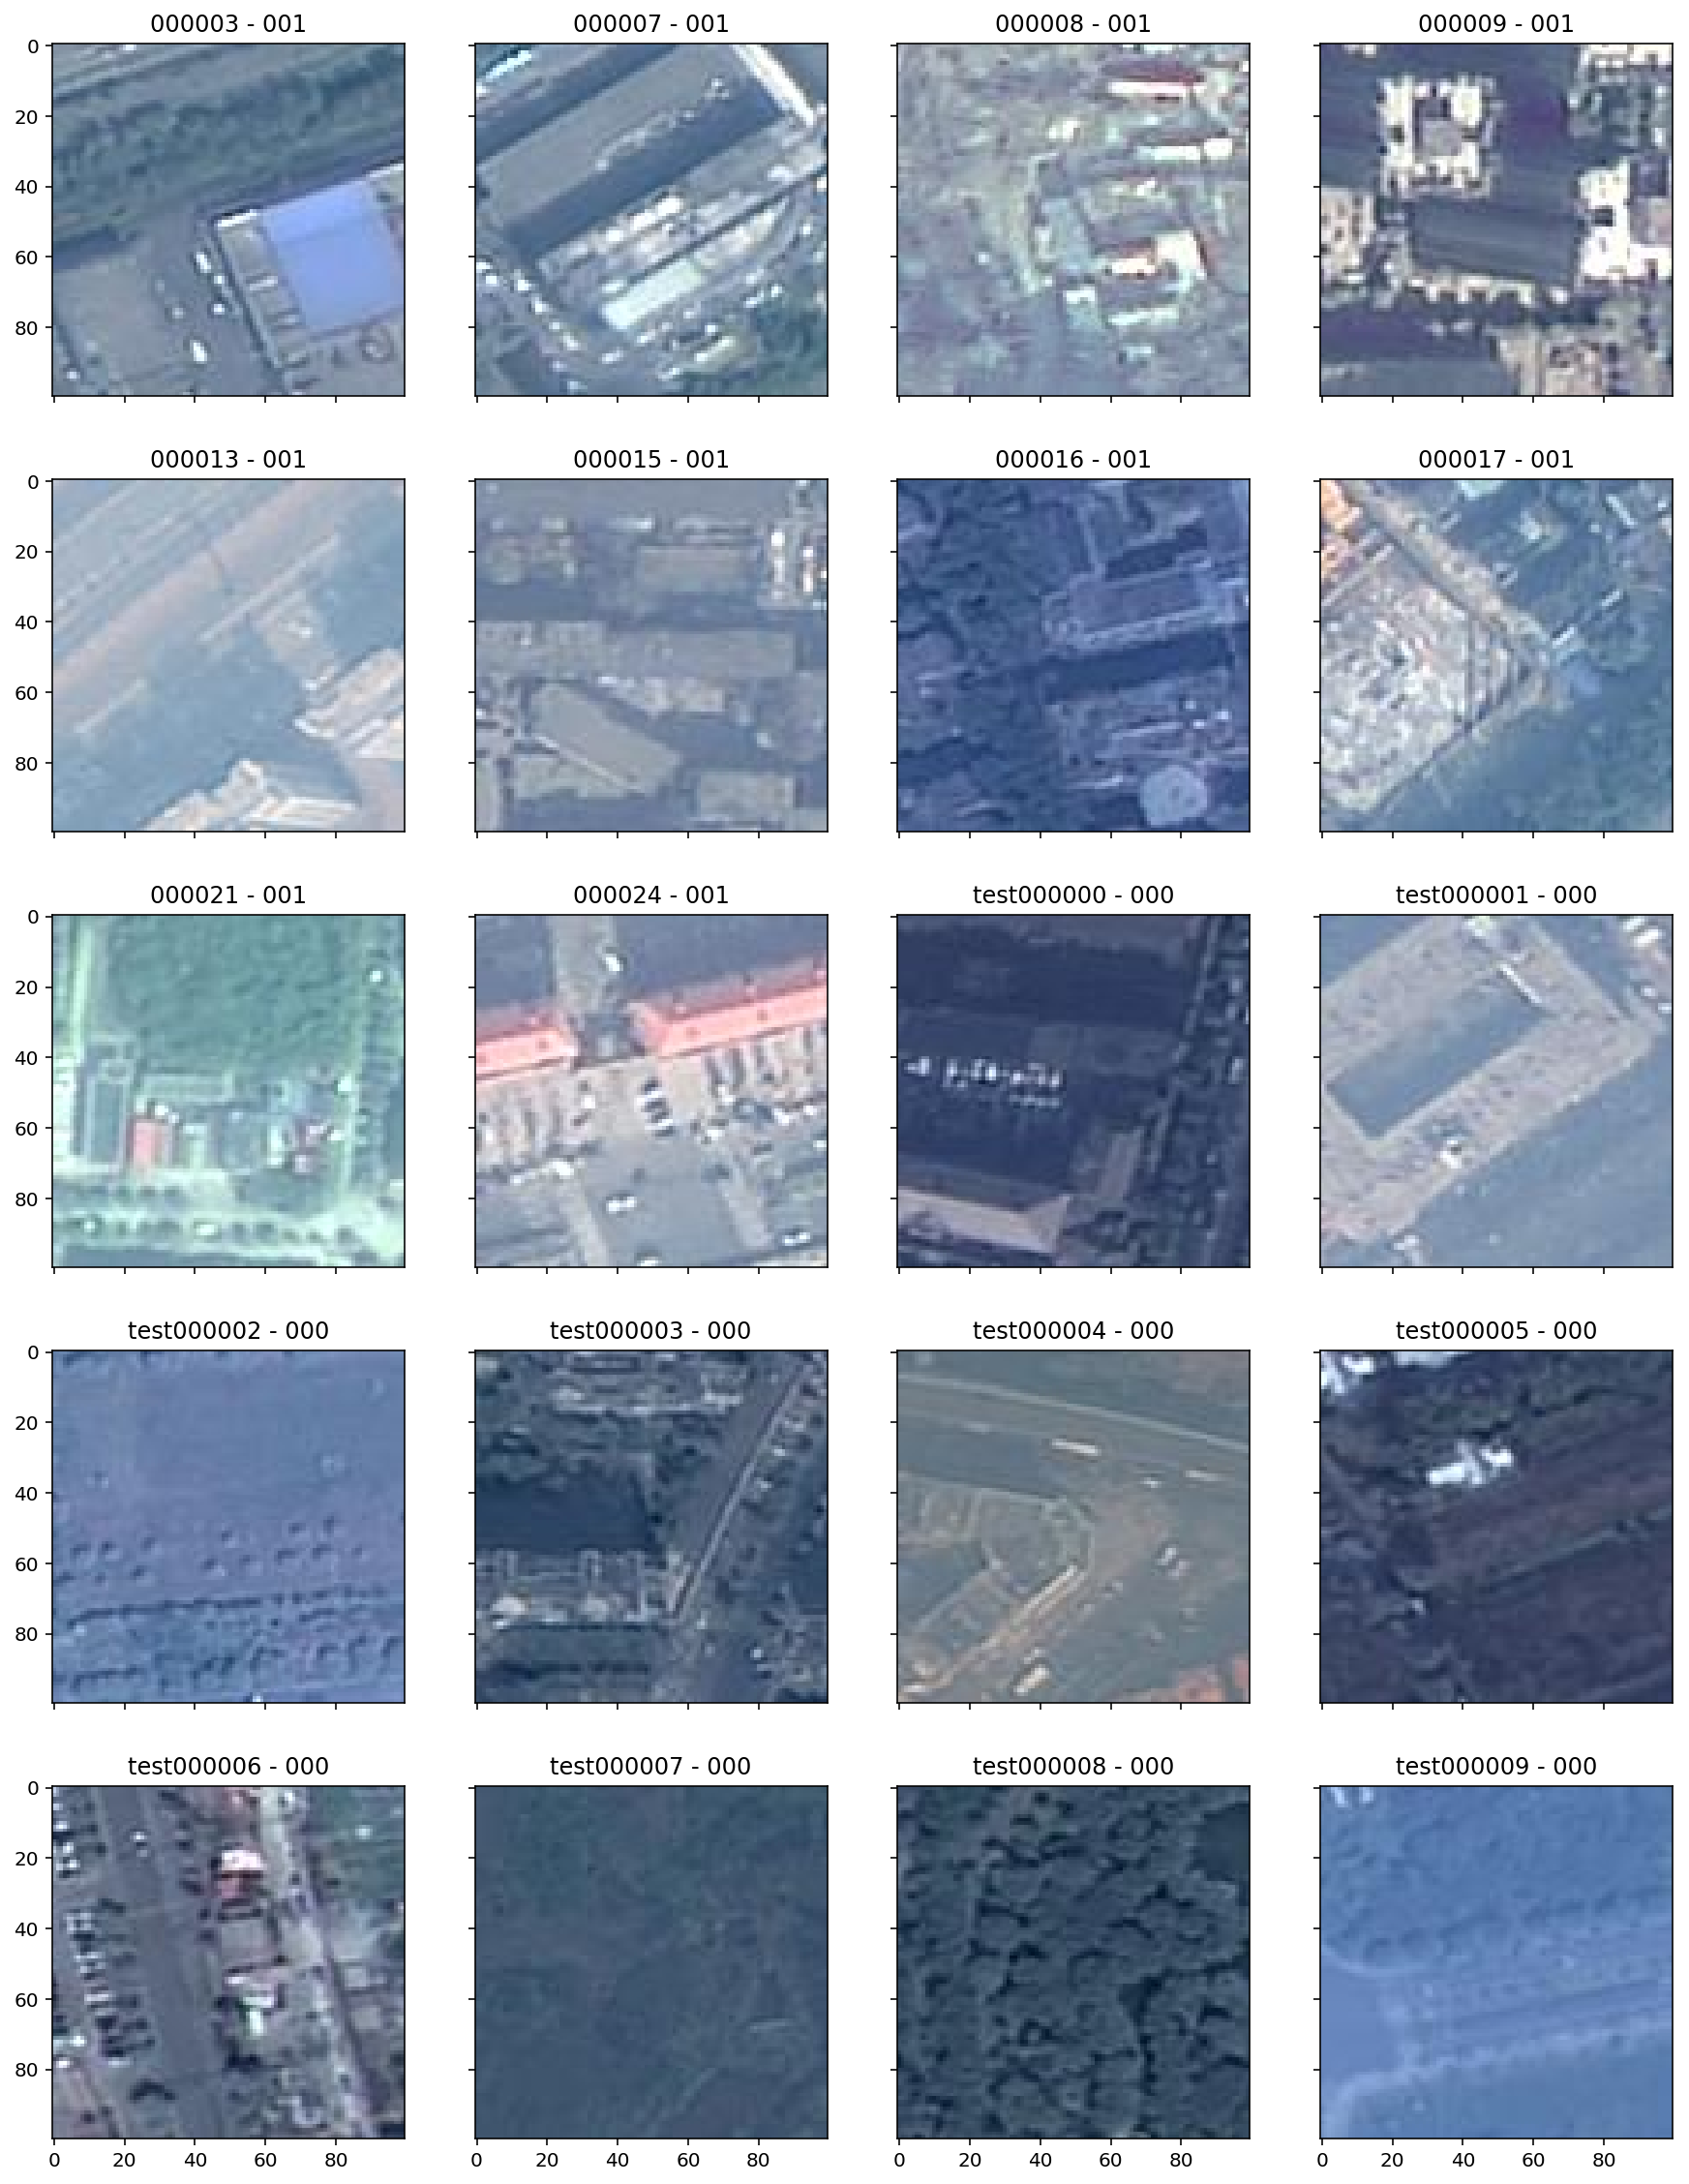

In [18]:
plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (filePath, label) in enumerate(train_csv):
    img = np.array(Image.open(filePath))
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(filePath[-14:-8], label))
    if i == 9:
        break
for (filePath, label) in test_csv:
    i += 1
    img = np.array(Image.open(filePath))
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format("test"+filePath[-10:-4], label))
    if i == 19:
        break

## 1.3 Haze Removal using Dark Channel Prior

In [21]:
from HazeRemoval import getRecoverScene, img_dehaze

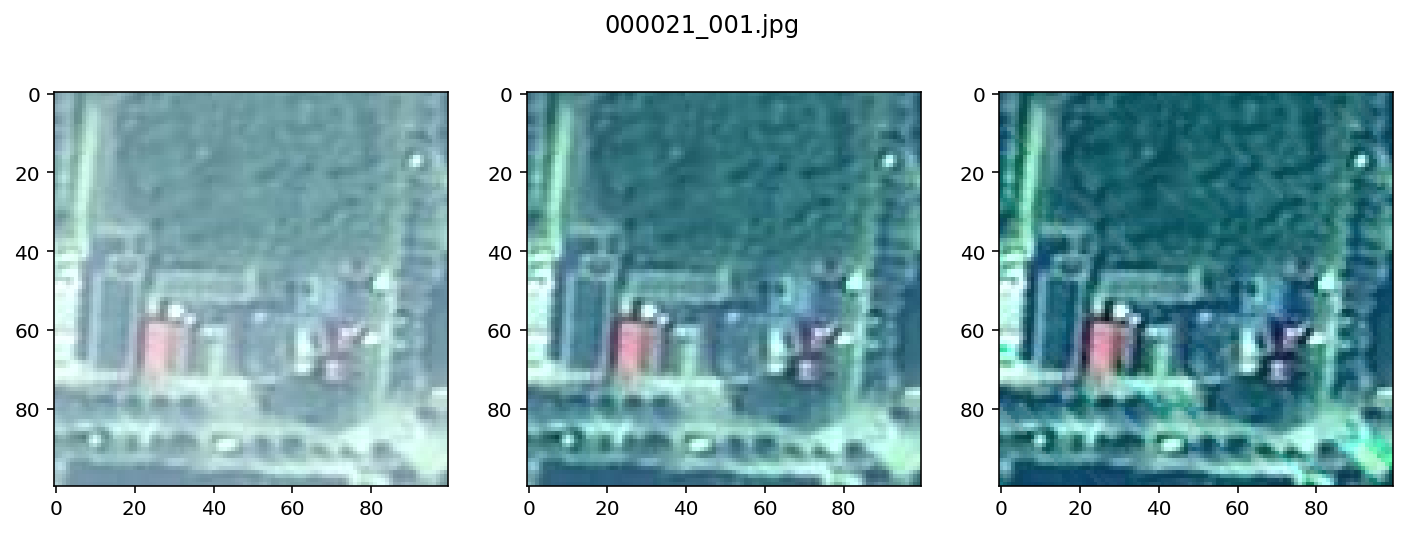

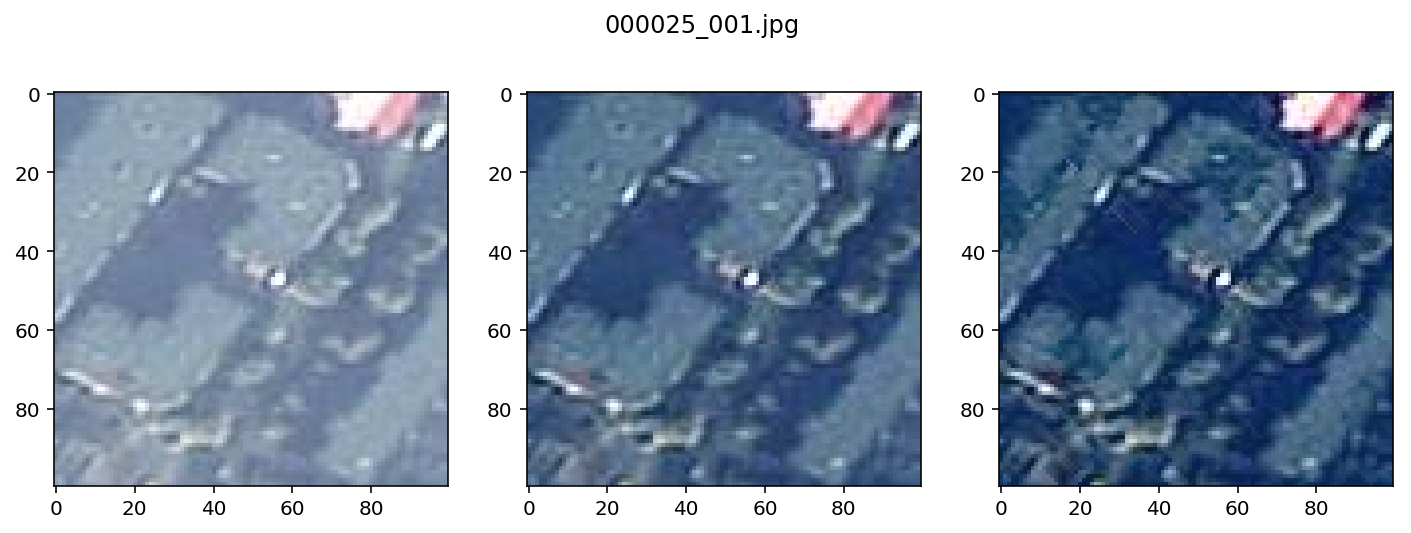

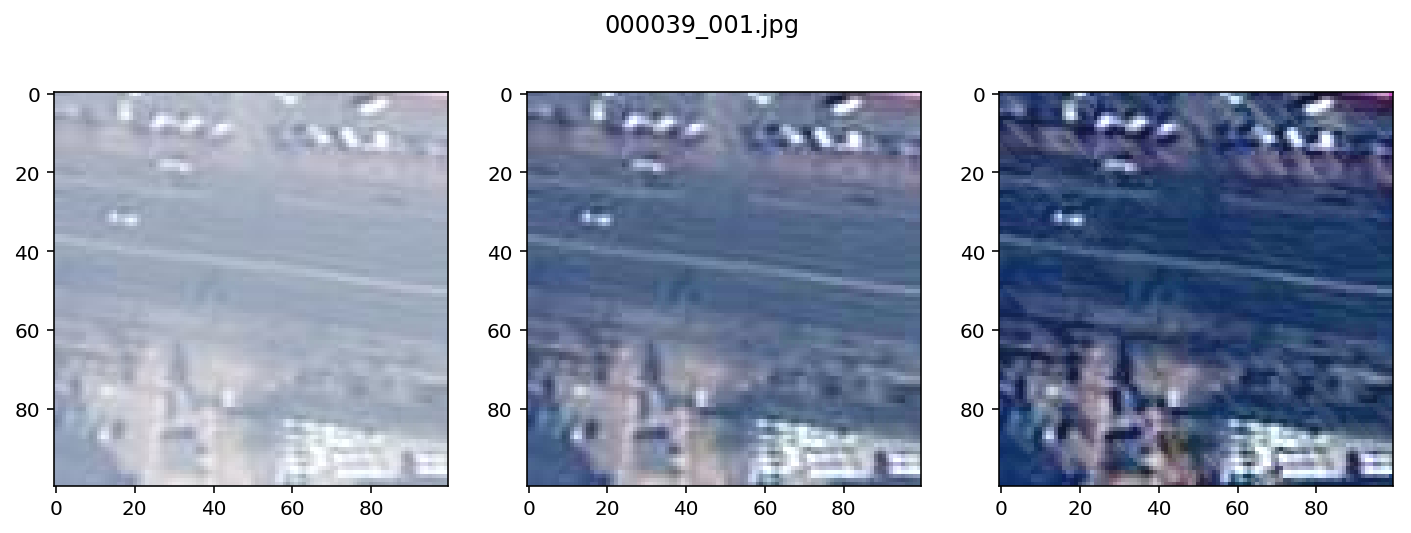

In [22]:
Hazy_img_idx = [8, 10 ,14]#range(2,5)

for i in Hazy_img_idx:    
     
    filepath = train_csv[i][0]
    img = np.array(Image.open(filepath))  #0-255    
    
    dehazed_img1 = getRecoverScene(img, refine=True, omega=0.75)
    dehazed_img2 = getRecoverScene(img, refine=False)

    fig = plt.figure()
    fig.set_size_inches(12, 4)
    fig.suptitle(filepath[-14:], fontsize=12)

    plt.subplot(131)
    plt.imshow(img)

    plt.subplot(132)
    plt.imshow(dehazed_img1)
    
    plt.subplot(133)
    plt.imshow(dehazed_img2)
    
    plt.show()

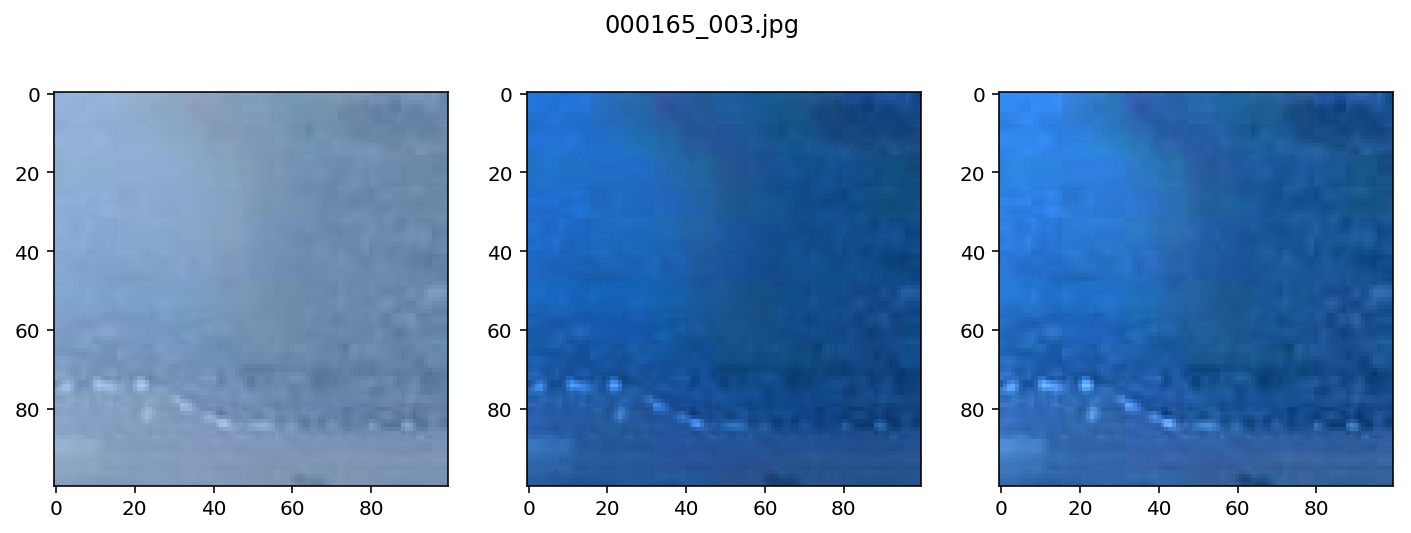

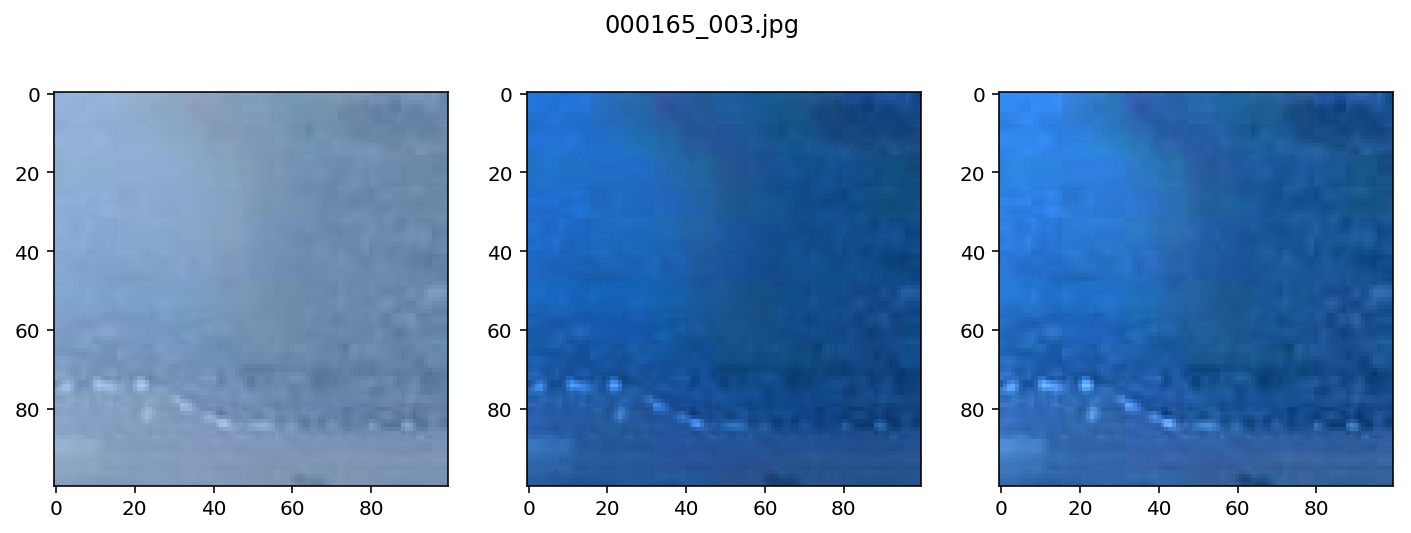

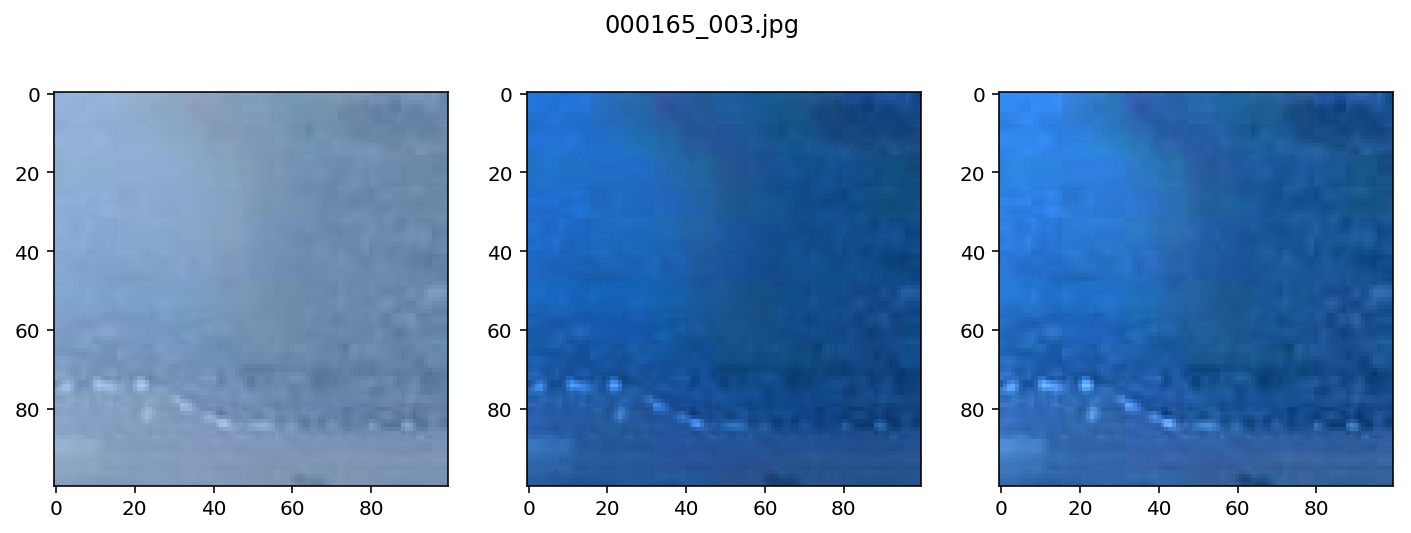

In [133]:
Hazy_img_idx = [234, 235 , 236]#range(2,5)

for i in Hazy_img_idx:    
     
    filepath = train_csv[i][0]
    img = cv2.imread(filepath)  #0-255    
    
    dehazed_img1 = getRecoverScene(img, refine=True)
    dehazed_img2 = (deHaze(img/255.0)*255).astype('uint8')

    fig = plt.figure()
    fig.set_size_inches(12, 4)
    fig.suptitle(filepath[-14:], fontsize=12)

    plt.subplot(131)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.subplot(132)
    plt.imshow(cv2.cvtColor(dehazed_img1, cv2.COLOR_BGR2RGB))
    
    plt.subplot(133)
    plt.imshow(cv2.cvtColor(dehazed_img2, cv2.COLOR_BGR2RGB))
    
    plt.show()

In [14]:
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool

In [12]:
if __name__ == "__main__":
    p = Pool()

    for (filePath, label) in tqdm(train_csv):
        p.apply_async(img_dehaze, args=(filePath, ))
    p.close()
    p.join()

100%|█████████████████████████████████████████████████████████████████████████| 40000/40000 [00:03<00:00, 13041.14it/s]


In [23]:
from imgaug import augmenters as iaa

In [24]:
flip = [iaa.Noop(),
iaa.Fliplr(1)]
aff = [ iaa.Affine(rotate=0),
        iaa.Affine(rotate=90),
        iaa.Affine(rotate=180),
        iaa.Affine(rotate=270)]

seq_list = []
for i in range(2):
    for j in range(4):
        img_aug = iaa.Sequential([flip[i], aff[j]])
        seq_list.append(img_aug)

In [29]:
import random

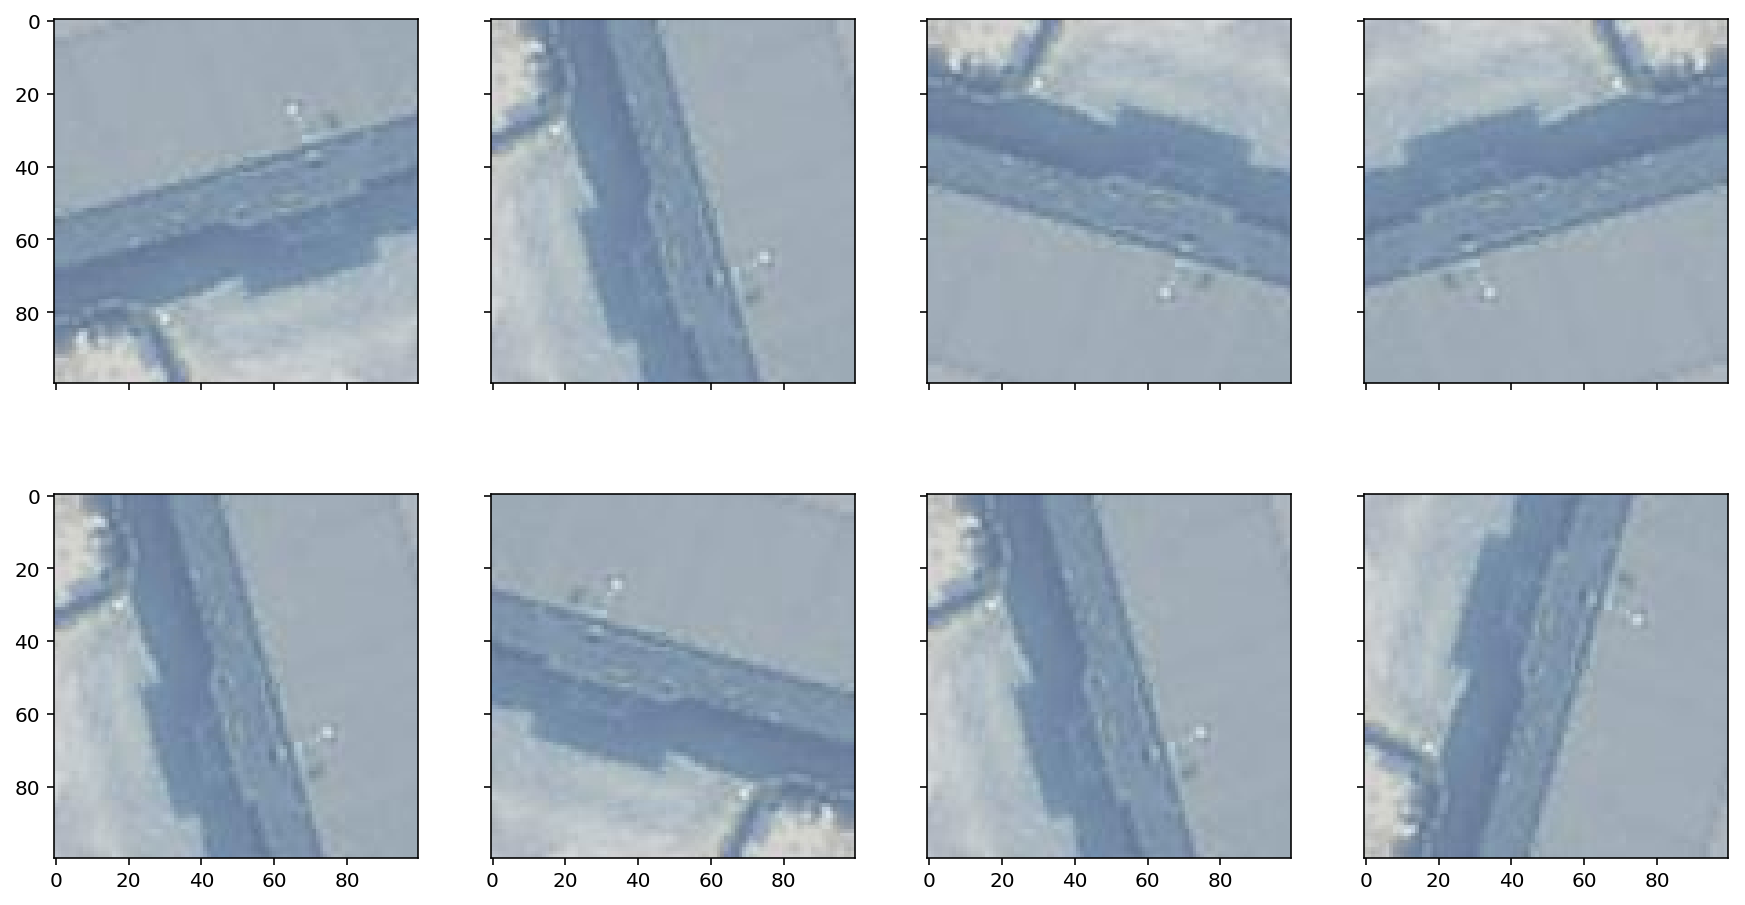

In [31]:
plt.rc('axes', grid=False)
_, axs = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(15, 8))
axs = axs.ravel()
img_orig = np.array(Image.open(filePath))
for i in range(8):
    img = random.choice(seq_list).augment_image(img_orig)
    axs[i].imshow(img)
#     im = Image.fromarray(img)
#     im.save("your_file.jpg")

## Image Outliars

In [23]:
import cv2

In [7]:
train_df = pd.read_csv("./dataset/final_train.csv")
test_df = pd.read_csv("./dataset/final_test.csv")

In [25]:
def calculate_b_ratio(_path):
    img = np.array(Image.open(_path))
    return np.bincount(img.ravel())[0] / 30000
def all_same_pixel(_path):
    img = np.sum(cv2.imread(_path), 2)
    return [np.max(img), np.min(img)]

In [29]:
train_df.head()

,Id,Target
0,./dataset/final_train/001\000003_001.jpg,0
1,./dataset/final_train/001\000007_001.jpg,0
2,./dataset/final_train/001\000008_001.jpg,0
3,./dataset/final_train/001\000009_001.jpg,0
4,./dataset/final_train/001\000013_001.jpg,0


In [31]:
train_df["black_ratio"] = train_df.Id_x.apply(lambda x: calculate_b_ratio(x))
test_df["black_ratio"] = test_df.Id_x.apply(lambda x: calculate_b_ratio(x))

In [83]:
train_df["max_min_pixel"] = train_df.Id_x.apply(lambda x: all_same_pixel(x))
test_df["max_min_pixel"] = test_df.Id_x.apply(lambda x: all_same_pixel(x))

In [86]:
train_df["same_pixel"] = train_df.max_min_pixel.apply(lambda x: (x[0] - x[1]))
test_df["same_pixel"] = test_df.max_min_pixel.apply(lambda x: (x[0] - x[1]))

In [18]:
# train_df.Id = train_df.Id.apply(lambda x: x.replace("train", "train_dehaze"))
# test_df.Id = test_df.Id.apply(lambda x: x.replace("test", "test_dehaze"))

In [3]:
train_df.head()

,Id_x,Target,black_ratio
0,./dataset/final_train/001\000003_001.jpg,1,0.0
1,./dataset/final_train/001\000007_001.jpg,1,0.0
2,./dataset/final_train/001\000008_001.jpg,1,0.0
3,./dataset/final_train/001\000009_001.jpg,1,0.0
4,./dataset/final_train/001\000013_001.jpg,1,0.0


In [4]:
test_df.head()

,Id_x,Target,black_ratio
0,./dataset/final_test/000000.jpg,0,0.0
1,./dataset/final_test/000001.jpg,0,0.0
2,./dataset/final_test/000002.jpg,0,0.0
3,./dataset/final_test/000003.jpg,0,0.0
4,./dataset/final_test/000004.jpg,0,0.0


In [90]:
test_df.loc[test_df.same_pixel<50].describe()

,black_ratio,basename,same_pixel
count,97.000000,97.000000,97.000000
mean,0.340206,3287.701031,13.969072
std,0.476240,2455.716707,14.348674
min,0.000000,15.000000,0.000000
25%,0.000000,1277.000000,0.000000
50%,0.000000,2596.000000,12.000000
75%,1.000000,4518.000000,21.000000
max,1.000000,9726.000000,49.000000


In [66]:
test_df.iloc[15].Id_x

'./dataset/test\\000015.jpg'

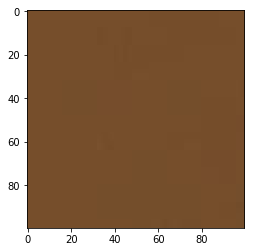

In [73]:
plt.imshow(cv2.imread(test_df.iloc[15].Id_x))

In [92]:
test_df.iloc[324]

Id_x                        ./dataset/test\000324.jpg
black_ratio                                         0
basename                                          324
Id_y             ./dataset/test_visitarray/000324.npy
max_min_pixel                              [583, 516]
same_pixel                                         67
Name: 324, dtype: object

In [96]:
test_df.loc[test_df.same_pixel<=70].Id_x

15      ./dataset/test\000015.jpg
150     ./dataset/test\000150.jpg
163     ./dataset/test\000163.jpg
177     ./dataset/test\000177.jpg
187     ./dataset/test\000187.jpg
317     ./dataset/test\000317.jpg
320     ./dataset/test\000320.jpg
324     ./dataset/test\000324.jpg
394     ./dataset/test\000394.jpg
637     ./dataset/test\000637.jpg
692     ./dataset/test\000692.jpg
751     ./dataset/test\000751.jpg
758     ./dataset/test\000758.jpg
767     ./dataset/test\000767.jpg
855     ./dataset/test\000855.jpg
862     ./dataset/test\000862.jpg
930     ./dataset/test\000930.jpg
977     ./dataset/test\000977.jpg
1004    ./dataset/test\001004.jpg
1007    ./dataset/test\001007.jpg
1015    ./dataset/test\001015.jpg
1130    ./dataset/test\001130.jpg
1149    ./dataset/test\001149.jpg
1170    ./dataset/test\001170.jpg
1196    ./dataset/test\001196.jpg
1217    ./dataset/test\001217.jpg
1225    ./dataset/test\001225.jpg
1243    ./dataset/test\001243.jpg
1277    ./dataset/test\001277.jpg
1327    ./data

In [33]:
train_df.loc[train_df.black_ratio>0.3].describe()

,Target,black_ratio
count,1341.000000,1341.0
mean,3.257271,1.0
std,2.503466,0.0
min,1.000000,1.0
25%,1.000000,1.0
50%,2.000000,1.0
75%,6.000000,1.0
max,9.000000,1.0


In [5]:
# train_df.loc[(train_df.black_ratio>0.3)|(train_df.same_pixel<=70)].describe()

In [35]:
train_df.to_csv("./dataset/final_train.csv", index=False)

In [36]:
test_df.to_csv("./dataset/final_test.csv", index=False)

# Data preprocessing

In [2]:
import time
import sys
import datetime

In [3]:
from utils import visit2array7

D:\Softwares\Anaconda3\envs\test\lib\site-packages\tqdm\autonotebook\__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [17]:
train_df = pd.read_csv("./dataset/final_train.csv")
test_df = pd.read_csv("./dataset/final_test.csv")

In [4]:
train_visit_csv = []
for root, dirs, files in os.walk("./dataset/train_part/", topdown=True):
    for file in files:
        filePath = os.path.join(root, file)
        AreaID, CategoryID = file.split("_")
        train_visit_csv.append([filePath, CategoryID[:3]])

test_visit_csv = []
for root, dirs, files in os.walk("./dataset/test_part/", topdown=True):
    for file in files:
        filePath = os.path.join(root, file)
        AreaID, CategoryID = file, "000"
        test_visit_csv.append([filePath, CategoryID[:3]])

train_visit_df = pd.DataFrame(train_visit_csv, columns=["Id_y", "Target"])
train_visit_df.Target = pd.to_numeric(train_visit_df.Target)

test_visit_df = pd.DataFrame(test_visit_csv, columns=["Id_y", "Target"])
test_visit_df.Target = pd.to_numeric(test_visit_df.Target)

In [5]:
# 用字典查询代替类型转换，可以减少一部分计算时间
date2position = {}
datestr2dateint = {}
str2int = {}
for i in range(24):
    str2int[str(i).zfill(2)] = i

In [6]:
# 访问记录内的时间从2018年10月1日起，共182天
# 将日期按日历排列
for i in range(182):
    date = datetime.date(day=1, month=10, year=2018)+datetime.timedelta(days=i)
    date_int = int(date.__str__().replace("-", ""))
    date2position[date_int] = [i%7, i//7]
    datestr2dateint[str(date_int)] = date_int

In [23]:
data = np.load(train_df.Id_y[0])

In [24]:
varr7 = data[:, :, :24].copy()

In [26]:
varr182 = np.zeros((24,182))
for col in range(26):
    for row in range(7):
        varr182[:, row+7*col] = varr7[row, col, :]

In [31]:
varr7.shape

(7, 26, 24)

In [35]:
(varr7.transpose(2, 1, 0).reshape(24, 182, 1) == varr182.reshape(24, 182, 1)).all()

True

In [30]:
varr7.reshape(182, 24).T == varr182

array([[ True, False, False, ..., False, False,  True],
       [ True, False,  True, ...,  True, False,  True],
       [ True, False, False, ..., False, False,  True],
       ...,
       [ True,  True, False, ...,  True, False,  True],
       [ True, False, False, ..., False, False,  True],
       [ True, False, False, ..., False, False,  True]])

In [27]:
varr7.reshape(24, 182) == varr182

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True]])

In [7]:
train_df["basename"] = train_df.Id_x.apply(lambda x: int(os.path.basename(x)[:-8]))
train_visit_df["basename"] = train_visit_df.Id_y.apply(lambda x: int(os.path.basename(x)[:-8]))

NameError: name 'train_df' is not defined

In [7]:
test_df["basename"] = test_df.Id_x.apply(lambda x: int(os.path.basename(x)[:6]))
test_visit_df["basename"] = test_visit_df.Id_y.apply(lambda x: int(os.path.basename(x)[:6]))

In [15]:
(train_visit_df.sort_values("basename").Target.values - 1== train_df.sort_values("basename").Target.values).all()

True

In [7]:
date2position[datestr2dateint["20181113"]]

[1, 6]

In [8]:
datestr2dateint["20181113"]

20181113

In [9]:
def visit2array(strings, path, date2position, datestr2dateint):
    init = np.zeros((7, 26))
    path = path.replace("part", "partarray_u").replace("txt", "npy")
    if os.path.exists(path):
        pass
    else:
        for string in strings:
            for item in string.split(','):
                date = item[0:8]
                # x - 第几周
                # y - 第几天
                # z - 几点钟
                x, y = date2position[datestr2dateint[date]]
                init[x][y] += 1
            # return init

        _dir = os.path.dirname(path.strip("//"))
        if not os.path.exists(_dir):
            print("making dir -- ", _dir)
            os.makedirs(_dir)
        np.save(path, init)
#     np.save(path.replace("part", "partarray_u").replace("txt", "npy"), init)

In [3]:
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool

In [ ]:
if __name__ == "__main__":
    p = ThreadPool() 
    try:
        with tqdm(test_visit_csv) as t:
            for path, vlog in tqdm(test_visit_csv):
                data = pd.read_csv(path, delimiter="\t", header=None)
                data = data[1].values
                p.apply_async(visit2array, args=(data, path))#date2position, datestr2dateint, str2int, 
            p.close()
            p.join()
    except:
        t.close()
        raise
    t.close()

  8%|██████▏                                                                   | 8330/100000 [04:34<1:16:32, 19.96it/s]

 21%|████████████████                                                           | 21465/100000 [13:26<49:51, 26.25it/s]

 35%|█████████████████████████▎                                               | 34641/100000 [22:42<1:12:08, 15.10it/s]

 38%|███████████████████████████▍                                             | 37619/100000 [26:01<1:12:17, 14.38it/s]

 41%|█████████████████████████████▊                                           | 40816/100000 [29:32<1:12:09, 13.67it/s]

 44%|████████████████████████████████▏                                        | 44038/100000 [33:17<1:05:07, 14.32it/s]

 49%|████████████████████████████████████▌                                      | 48732/100000 [37:38<37:22, 22.86it/s]

 58%|███████████████████████████████████████████▌                               | 58152/100000 [43:13<40:34, 17.19it/s]

 66%|███████████████████████████

In [10]:
from utils import visit2array7, multi_task

In [28]:
train_visit_df.Id_y[0]

'0'

In [ ]:
train_visit_df.Id_y.isin

In [11]:
train_visit_df["Idir"] = train_visit_df.Id_y.apply(lambda x: int(x.split("part/")[1][0]))

In [12]:
train_visit_df1 = train_visit_df.loc[train_visit_df.Idir.isin([2, 7, 9])].copy()

In [15]:
train_visit_df1.drop(columns=["Idir"], inplace=True)

In [4]:
train_df = pd.read_csv("./dataset/final_train.csv")
test_df = pd.read_csv("./dataset/final_test.csv")

In [14]:
from utils import overwritearr

In [ ]:
train_df.iloc[:10]

In [15]:
if __name__ == "__main__":
    # train
    t0 = time.time()
    N = train_df.shape[0]
    print(N)
    num_cpu = 35 # cpu数量
    pool = Pool(num_cpu)

    results = []
    batch_num = N // num_cpu
    print('batch_num',batch_num)
    for i in range(num_cpu):
        if i == num_cpu-1:
            offset = N
        else:
            offset = (i+1)*batch_num
        task_train = train_df.iloc[i*batch_num : offset]#.values
        print('task',i,'shape',len(task_train))
        result = pool.apply_async(overwritearr,(task_train,))#, date2position, datestr2dateint
        results.append(result)
    pool.close()
    pool.join()
    print('finished',len(results))

    t1 = time.time()
    print('time', int(t1 - t0), 's')

400000
batch_num 11428
task 0 shape 11428
task 1 shape 11428
task 2 shape 11428
task 3 shape 11428
task 4 shape 11428
task 5 shape 11428
task 6 shape 11428
task 7 shape 11428
task 8 shape 11428
task 9 shape 11428
task 10 shape 11428
task 11 shape 11428
task 12 shape 11428
task 13 shape 11428
task 14 shape 11428
task 15 shape 11428
task 16 shape 11428
task 17 shape 11428
task 18 shape 11428
task 19 shape 11428
task 20 shape 11428
task 21 shape 11428
task 22 shape 11428
task 23 shape 11428
task 24 shape 11428
task 25 shape 11428
task 26 shape 11428
task 27 shape 11428
task 28 shape 11428
task 29 shape 11428
task 30 shape 11428
task 31 shape 11428
task 32 shape 11428
task 33 shape 11428
task 34 shape 11448
finished 35
time 1776 s


In [16]:
if __name__ == "__main__":
    # train
    t0 = time.time()
    N = train_visit_df1.shape[0]
    print(N)
    num_cpu = 30 # cpu数量
    pool = Pool(num_cpu)

    results = []
    batch_num = N // num_cpu
    print('batch_num',batch_num)
    for i in range(num_cpu):
        if i == num_cpu-1:
            offset = N
        else:
            offset = (i+1)*batch_num
        task_train = train_visit_df1.iloc[i*batch_num : offset].values
        print('task',i,'shape',len(task_train))
        result = pool.apply_async(multi_task,(task_train, date2position, datestr2dateint))
        results.append(result)
    pool.close()
    pool.join()
    print('finished',len(results))

    t1 = time.time()
    print('time', int(t1 - t0), 's')

120000
batch_num 4000
task 0 shape 4000
task 1 shape 4000
task 2 shape 4000
task 3 shape 4000
task 4 shape 4000
task 5 shape 4000
task 6 shape 4000
task 7 shape 4000
task 8 shape 4000
task 9 shape 4000
task 10 shape 4000
task 11 shape 4000
task 12 shape 4000
task 13 shape 4000
task 14 shape 4000
task 15 shape 4000
task 16 shape 4000
task 17 shape 4000
task 18 shape 4000
task 19 shape 4000
task 20 shape 4000
task 21 shape 4000
task 22 shape 4000
task 23 shape 4000
task 24 shape 4000
task 25 shape 4000
task 26 shape 4000
task 27 shape 4000
task 28 shape 4000
task 29 shape 4000
finished 30
time 942 s


In [24]:
path = (task_train[0][0])

In [30]:
v1 = np.load(path.replace("part", "partarray").replace("txt", "npy"))

In [35]:
v2 = np.load(path.replace("part", "partarray_u").replace("txt", "npy")).reshape((7, 26, 1))

In [36]:
v1.shape, v2.shape

((7, 26, 24), (7, 26, 1))

In [42]:
vs = np.sum(v1, 2, keepdims=True)

In [47]:
vs.shape

(7, 26, 1)

In [49]:
np.true_divide(vs, v2+1e-8)

(7, 26, 1)

In [37]:
np.concatenate([v1, v2], axis=2).shape

(7, 26, 25)

In [29]:
np.transpose(np.load(path.replace("part", "partarray").replace("txt", "npy")), (1,2,0)).shape

(26, 24, 7)

In [ ]:
if __name__ == "__main__":
    p = Pool() 
    with tqdm(train_visit_csv) as t:
        for path, vlog in t:
            data = pd.read_csv(path, delimiter="\t", header=None)
            data = data[1].values
            p.apply_async(visit2array, args=(data, path))
        p.close()
        p.join()

100%|████████████████████████████████████████████████████████████████████████| 400000/400000 [3:58:45<00:00, 27.92it/s]


In [20]:
train_visit_df.Id_y = train_visit_df.Id_y.apply(lambda x: x.replace("part", "partarray").replace("txt", "npy"))

test_visit_df.Id_y = test_visit_df.Id_y.apply(lambda x: x.replace("part", "partarray").replace("txt", "npy"))

In [22]:
train_df = pd.merge(train_df, train_visit_df, how="outer", on=["basename", "Target"])

In [32]:
test_df = pd.merge(test_df, test_visit_df, how="outer", on=["basename", "Target"])

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [27]:
train_df.Target = train_df.Target - 1
train_df.to_csv("./dataset/final_train.csv", index=False)

In [41]:
test_df.to_csv("./dataset/final_test.csv", index=False)

In [67]:
train_df.Id_x = train_df.Id_x.apply(lambda x: "."+ x.replace("set", "").replace("final_", "").replace("\\", r"/"))
train_df.Id_y = train_df.Id_y.apply(lambda x: (r"../data/npy/train_visit/" + os.path.basename(x)).replace(".npy", ".pkl"))
train_df.head()

,Id_x,Target,black_ratio,basename,Id_y
0,../data/train/001/000003_001.jpg,0,0.0,3,../data/npy/train_visit/000003_001.pkl
1,../data/train/001/000007_001.jpg,0,0.0,7,../data/npy/train_visit/000007_001.pkl
2,../data/train/001/000008_001.jpg,0,0.0,8,../data/npy/train_visit/000008_001.pkl
3,../data/train/001/000009_001.jpg,0,0.0,9,../data/npy/train_visit/000009_001.pkl
4,../data/train/001/000013_001.jpg,0,0.0,13,../data/npy/train_visit/000013_001.pkl


In [66]:
test_df.Id_x = test_df.Id_x.apply(lambda x: (r"../data/test/" + os.path.basename(x)))
test_df.Id_y = test_df.Id_y.apply(lambda x: (r"../data/npy/test_visit/" + os.path.basename(x)))
test_df.head()

,Id_x,Target,black_ratio,basename,Id_y
0,../data/test/000000.jpg,0,0.0,0,../data/npy/test_visit/000000.pkl
1,../data/test/000001.jpg,0,0.0,1,../data/npy/test_visit/000001.pkl
2,../data/test/000002.jpg,0,0.0,2,../data/npy/test_visit/000002.pkl
3,../data/test/000003.jpg,0,0.0,3,../data/npy/test_visit/000003.pkl
4,../data/test/000004.jpg,0,0.0,4,../data/npy/test_visit/000004.pkl


In [65]:
train_df.to_csv("./dataset/final_train1.csv", index=False)
test_df.to_csv("./dataset/final_test1.csv", index=False)

In [50]:
import os, pickle
import pandas as pd
from tqdm import tqdm
from multiprocessing.dummy import Pool as ThreadPool

def array2pkl(path, array):
    with open(path, 'wb') as f:
        pickle.dump(array, f)

def generate_array182(table=None):
    p = ThreadPool(40)
    with tqdm(table.Id_y) as t:
        for _path in t:
            with open(_path, "rb") as v:
                varray, vcount = pickle.load(v)
            new_varray = np.zeros((24, 182))
            for col in range(26):
                for row in range(7):
                    new_varray[:, row+7*col] = varray[row, col, :]
            _path = _path.replace("visit", "visit182").strip("//")
            _dir = os.path.dirname(_path)
            if not os.path.exists(_dir):
                print("making dir:", _dir)
                os.makedirs(_dir)
            p.apply_async(array2pkl, args=(_path, (new_varray, vcount), ))
        p.close()
        p.join()
    t.close()
    

if __name__ == "__main__":
    train_df = pd.read_csv("./dataset/final_train1.csv")
    test_df = pd.read_csv("./dataset/final_test1.csv")
    generate_array182(train_df)
    generate_array182(test_df)

In [30]:
p = ThreadPool()
with tqdm(train_df.Id_y) as t:
    for _path in t:
        varray = np.load(_path)
        new_varray = np.zeros((24, 182))
        for col in range(26):
            for row in range(7):
        #         print(row+7*col)
                new_varray[:, row+7*col] = varray[row, col, :]
        _path = _path.replace("array", "arraynew").strip("//")
        _dir = os.path.dirname(_path)
        if not os.path.exists(_dir):
            os.makedirs(_dir)
        p.apply_async(np.save, args=(_path, new_varray, ))
    p.close()
    p.join()
t.close()

100%|█████████████████████████████████████████████████████████████████████████| 400000/400000 [40:43<00:00, 163.69it/s]


In [10]:
for _path in tqdm(test_df.Id_y):
    varray = np.load(_path)
    new_varray = np.zeros((24, 182))
    for col in range(26):
        for row in range(7):
    #         print(row+7*col)
            new_varray[:, row+7*col] = varray[row, col, :]
    np.save(_path.replace("array", "arraynew"), new_varray)

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [21:15<00:00, 78.40it/s]


# Acc_CE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import numpy as np

In [199]:
# 预测值f(x) 构造样本，神经网络输出层
inputs_tensor = torch.FloatTensor( [
 [10, 2, 1,-2,-3],
 [-1,-6,-0,-3,-5],
 [-5, 4, 8, 2, 1]
 ])
inputs_tensor = torch.FloatTensor( np.array([
 [10, 2, 1,-2,-3],
 [1, 6, 0, 9, 5],
 [-5, 4, 8, 2, 1]
 ]))
# 真值y
targets_tensor = torch.LongTensor([1,3,2])
# targets_tensor = torch.LongTensor([1])

inputs_variable = autograd.Variable(inputs_tensor, requires_grad=True) 
targets_variable = autograd.Variable(targets_tensor)
print('input tensor(nBatch x nClasses): {}'.format(inputs_tensor.shape))
print('target tensor shape: {}'.format(targets_tensor.shape))

input tensor(nBatch x nClasses): torch.Size([3, 5])
target tensor shape: torch.Size([3])


In [185]:
loss = nn.CrossEntropyLoss()
output = loss(inputs_variable, targets_variable)
# output.backward()
print('pytorch 内部实现的CrossEntropyLoss: {}'.format(output))

pytorch 内部实现的CrossEntropyLoss: 2.6960856914520264


In [197]:
acc_loss = 1 - accuracy(inputs_variable, targets_variable, np=False)/100
torch.add(F.cross_entropy(inputs_variable, targets_variable), acc_loss)